<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [In-Depth: Manifold Learning](05.10-Manifold-Learning.ipynb) | [Contents](Index.ipynb) | [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# In Depth: k-Means Clustering

In the previous few sections, we have explored one category of unsupervised machine learning models: dimensionality reduction.
Here we will move on to another class of unsupervised machine learning models: clustering algorithms.
Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as *k-means clustering*, which is implemented in ``sklearn.cluster.KMeans``.

We begin with the standard imports:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

## Introducing k-Means

The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

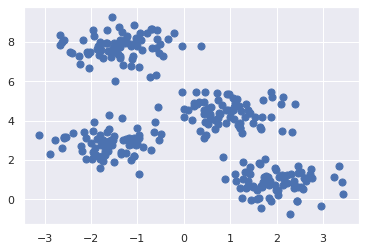

In [ ]:
# from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:
[sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# alguns atributos da classe KMeans
print(kmeans.cluster_centers_)
print(kmeans.labels_,len(kmeans.labels_))

[[-1.58438467  2.83081263]
 [ 0.94973532  4.41906906]
 [ 1.98258281  0.86771314]
 [-1.37324398  7.75368871]]
[2 3 1 3 2 2 0 1 3 3 0 3 1 3 2 1 1 2 0 0 2 2 1 0 0 1 2 1 0 1 3 3 1 3 3 3 3
 3 0 2 1 0 1 1 0 0 3 0 3 2 0 2 3 2 2 0 3 0 3 2 3 1 3 0 0 0 3 2 3 0 1 0 3 0
 0 3 0 1 2 3 2 1 2 2 3 1 2 1 3 3 1 2 3 0 0 1 2 2 1 0 3 2 3 2 1 2 2 1 3 1 0
 0 2 3 2 1 3 2 2 1 0 2 0 2 2 2 2 0 2 0 3 0 0 2 3 0 0 3 1 3 3 0 1 0 1 0 3 1
 3 3 3 1 3 1 2 0 3 0 2 1 3 1 1 2 1 0 0 1 2 1 1 3 2 1 0 3 2 2 1 0 2 1 0 0 1
 1 1 1 2 3 1 0 1 1 0 0 0 1 0 3 1 0 2 0 1 3 0 3 1 3 1 0 1 1 3 0 0 2 2 1 3 2
 2 0 2 0 1 3 3 1 1 3 1 2 0 1 2 0 3 0 2 1 2 3 3 3 3 0 0 3 1 0 2 1 0 0 0 2 2
 3 1 1 0 2 3 0 1 3 1 2 2 0 0 1 2 2 2 1 3 3 2 2 1 2 2 2 3 0 3 1 2 2 3 3 3 2
 2 1 3 0] 300


Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

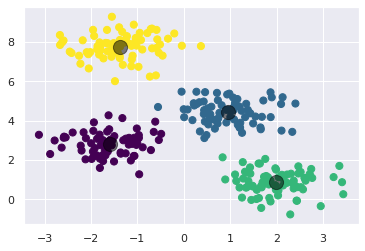

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

### Example 2: *k*-means for color compression

One interesting application of clustering is in color compression within images.
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

For example, consider the image shown in the following figure, which is from the Scikit-Learn ``datasets`` module (for this to work, you'll have to have the ``pillow`` Python package installed).

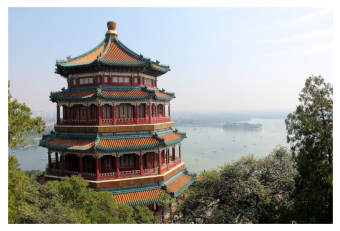

In [ ]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

The image itself is stored in a three-dimensional array of size ``(height, width, RGB)``, containing red/blue/green contributions as integers from 0 to 255:

In [ ]:
china.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space.
We will reshape the data to ``[n_samples x n_features]``, and rescale the colors so that they lie between 0 and 1:

In [ ]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

In [ ]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

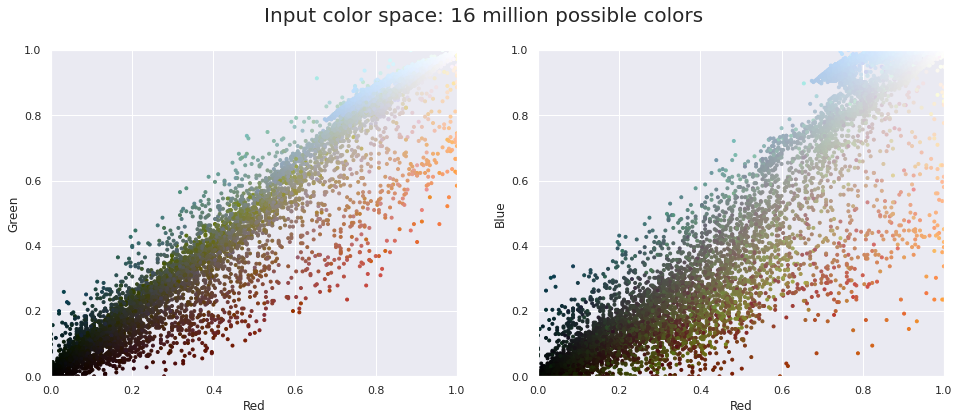

In [ ]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using a *k*-means clustering across the pixel space.
Because we are dealing with a very large dataset, we will use the mini batch *k*-means, which operates on subsets of the data to compute the result much more quickly than the standard *k*-means algorithm:

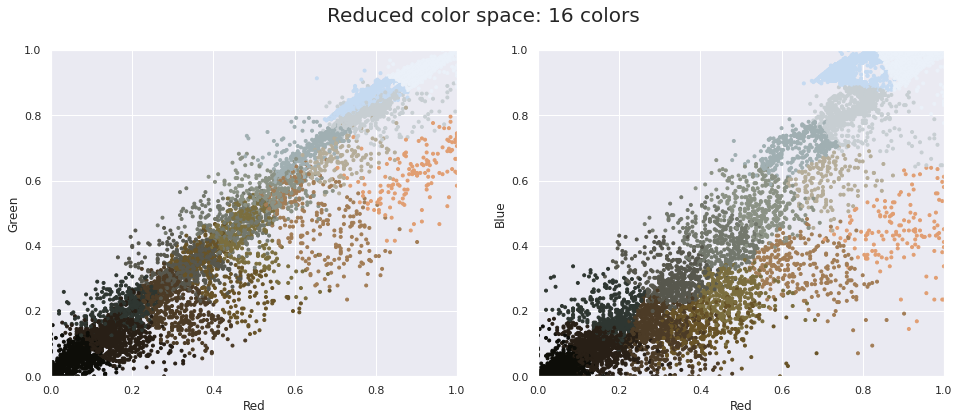

In [ ]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center.
Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

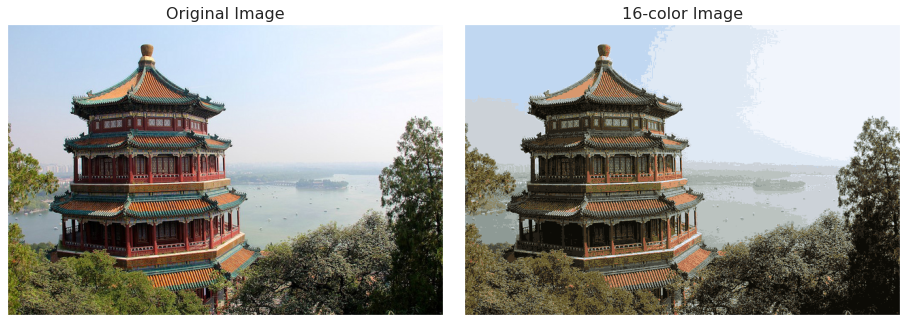

In [ ]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable.
This image on the right achieves a compression factor of around 1 million!
While this is an interesting application of *k*-means, there are certainly better way to compress information in images.
But the example shows the power of thinking outside of the box with unsupervised methods like *k*-means.


# Image Segmentation Using Mean-Shift Clustering Algorithm
[sklearn.cluster.MeanShift](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)


[sklearn.cluster.estimate_bandwidth](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.estimate_bandwidth.html)

In [ ]:
import numpy as np
import pandas as pd
import cv2
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import filters
from skimage import util
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import MeanShift, estimate_bandwidth
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
from google.colab.patches import cv2_imshow # for image display
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files as FILE
from google.colab.patches import cv2_imshow # for image display
import os
import requests
"""Download da imagem de teste"""
img_data = requests.get('https://st2.depositphotos.com/7036298/10774/i/600/depositphotos_107748090-stock-photo-red-green-apples-group-isolated.jpg').content
# https://st2.depositphotos.com/7036298/10774/i/600/depositphotos_107748090-stock-photo-red-green-apples-group-isolated.jpg
# https://portal.cin.ufpe.br/wp-content/uploads/2021/03/cin-ufpe-e1615823081807.jpg
with open('cin.jpg', 'wb') as handler:
    handler.write(img_data)

Quantidade de clusters:  9


Text(0.5, 1.0, 'Segmented Image')

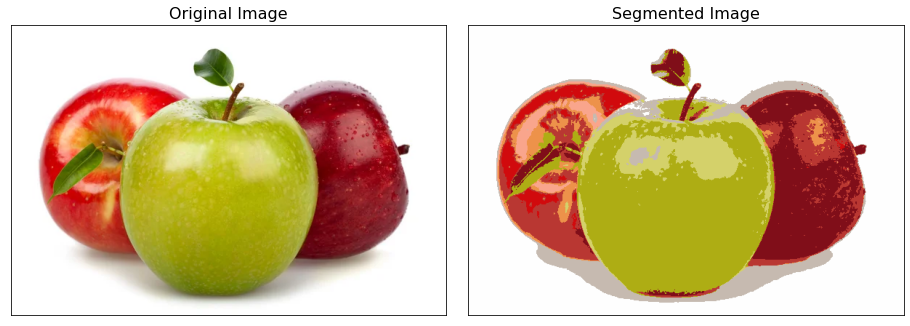

In [ ]:

img = cv2.imread("cin.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

data = img / 255.0 # use 0...1 scale

data = data.reshape(img.shape[0] * img.shape[1], 3)

# The following bandwidth can be automatically detected using
# bandwidth = estimate_bandwidth(data, n_samples=1000)
bandwidth = estimate_bandwidth(data, quantile=0.1, n_samples=1000)
# bandwidth = estimate_bandwidth(data, quantile=0.4, n_samples=1000)
# bandwidth = estimate_bandwidth(data, quantile=0.5, n_samples=1000)
# print(bandwidth)

# configurar bin_seeding para True acelerará o algoritmo porque menos sementes serão inicializadas.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(data)

labels = ms.labels_ #(img.shape[0] * img.shape[1],)
cluster_centers = ms.cluster_centers_ # (qtde_clusters,3)

print('Quantidade de clusters: ', len(cluster_centers))

new_colors = cluster_centers[ms.predict(data)]
img_recolored = new_colors.reshape(img.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))

fig.subplots_adjust(wspace=0.05)
ax[0].imshow(img)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(img_recolored)
ax[1].set_title('Segmented Image', size=16)

# cv2_imshow(china_recolored*255)